# HAMP
The following example demonstrates the use of HAMP raw data collected during HALO-AC3. The HALO Microwave Package (HAMP) belongs to Max-Planck Institute for Meteorology Hamburg, DLR/IPA, and the University of Hamburg. The package consists of a 35 GHz pulsed radar and three passive microwave modules with a frequency range of 22 to 183.31 +/- 7.5 GHz.

More information on the instrument can be found in [Mech et al. (2014)](https://amt.copernicus.org/articles/7/4539/2014/) and [Ewald et al. 2019](https://amt.copernicus.org/articles/12/1815/2019/). If you have questions or if you would like to use the data for a publication, please don't hesitate to get in contact with the dataset authors as stated in the dataset attributes `contact` or `author`.

## Data access

In [1]:
import os

# local caching
try:
    from dotenv import load_dotenv

    load_dotenv()

    local_storage = os.environ['INTAKE_CACHE']
except ImportError:
    local_storage = '/tmp/'

kwds = {'simplecache': dict(
    cache_storage=local_storage, 
    same_names=True
)}

To analyse the data they first have to be loaded by importing the (AC)<sup>3</sup> airborne module and load the meta data catalog. To do so, the ac3airborne package has to be installed. More information on how to do that and about the catalog can be found [here](https://github.com/igmk/ac3airborne-intake#ac3airborne-intake-catalogue).

In [2]:
import ac3airborne

Show available data sets

In [3]:
cat = ac3airborne.get_intake_catalog()

In [4]:
meta = ac3airborne.get_flight_segments()

In [5]:
flight = 'HALO-AC3_HALO_RF03'

Get takeoff and landing times.

In [6]:
takeoff = meta['HALO-AC3']['HALO'][flight]['takeoff']
landing = meta['HALO-AC3']['HALO'][flight]['landing']

Load the HAMP radiometer and radar data from PANGAEA. We use the `kwds` for caching as defined above.

In [7]:
import datetime

hamp_radiometer = cat['HALO-AC3']['HALO']['HAMP_RADIOMETER'][flight](storage_options=kwds).to_dask().sel(time=slice(takeoff, landing))
hamp_radar = cat['HALO-AC3']['HALO']['HAMP_RADAR'][flight](storage_options=kwds).to_dask().sel(time=slice(takeoff,landing))


/net/sever/mech/miniconda3/envs/howtoac3/lib/python3.11/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),
/net/sever/mech/miniconda3/envs/howtoac3/lib/python3.11/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),


Make 2D field for time and height for pcolormesh plot.

In [8]:
import numpy as np
height_2d = np.tile(hamp_radar.height,(len(hamp_radar.time),1))
time_2d = np.tile(hamp_radar.time,(len(hamp_radar.height),1)).T

In [9]:
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import cm
plt.style.use("../../mplstyle/book")

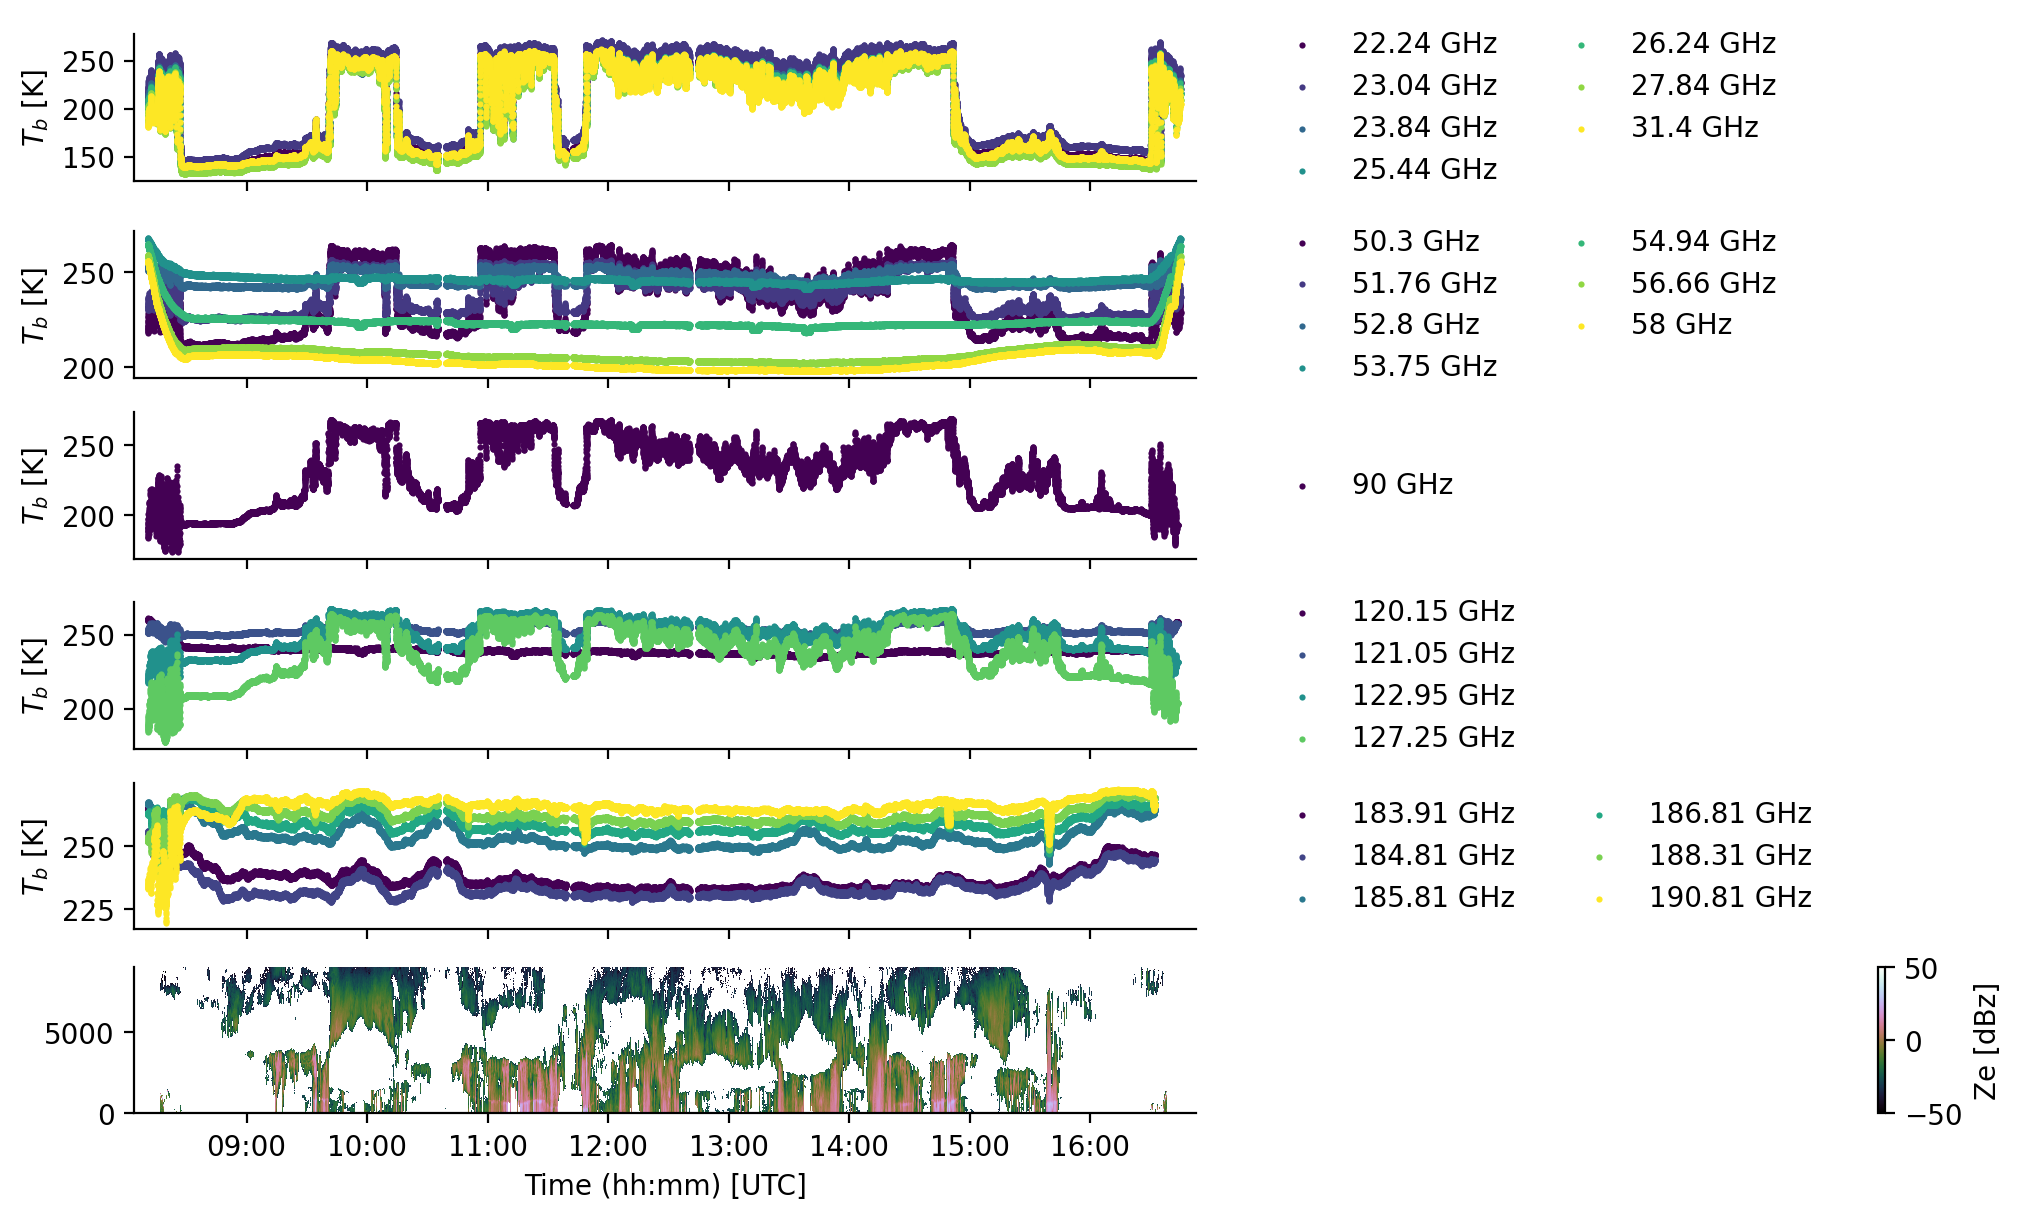

In [10]:
fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(6, 1, sharex=True, gridspec_kw=dict(height_ratios=(1, 1, 1, 1, 1, 1)))

kwargs = dict(s=5, linewidths=0)
colors = cm.get_cmap('viridis', 7).colors
for i in range(0, 7):
    ax1.scatter(hamp_radiometer.time, hamp_radiometer.TB[:,i], label='%g GHz'%hamp_radiometer.freq[i], color = colors[i], **kwargs)

for i in range(7, 14):
    ax2.scatter(hamp_radiometer.time, hamp_radiometer.TB[:,i], label='%g GHz'%hamp_radiometer.freq[i], color = colors[i-7], **kwargs)

ax1.legend(frameon=False, bbox_to_anchor=(1.05, 0.5), loc='center left', ncol=2)
ax2.legend(frameon=False, bbox_to_anchor=(1.05, 0.5), loc='center left', ncol=2)

ax1.set_ylabel('$T_b$ [K]')
ax2.set_ylabel('$T_b$ [K]')

colors = cm.get_cmap('viridis', 5).colors
for i in range(14, 15):
    ax3.scatter(hamp_radiometer.time, hamp_radiometer.TB[:,i], label='%g GHz'%hamp_radiometer.freq[i], color = colors[0], **kwargs)

for i in range(15, 19):
    ax4.scatter(hamp_radiometer.time, hamp_radiometer.TB[:,i], label='%g GHz'%hamp_radiometer.freq[i], color = colors[i-15], **kwargs)

ax3.legend(frameon=False, bbox_to_anchor=(1.05, 0.5), loc='center left')
ax4.legend(frameon=False, bbox_to_anchor=(1.05, 0.5), loc='center left')
    
ax3.set_ylabel('$T_b$ [K]')
ax4.set_ylabel('$T_b$ [K]')

colors = cm.get_cmap('viridis', 6).colors
for i in range(19, 25):
    ax5.scatter(hamp_radiometer.time, hamp_radiometer.TB[:,i], label='%g GHz'%hamp_radiometer.freq[i], color = colors[i-19], **kwargs)

ax5.legend(frameon=False, bbox_to_anchor=(1.05, 0.5), loc='center left', ncol=2)

ax5.set_ylabel('$T_b$ [K]')

im = ax6.pcolormesh(time_2d, height_2d, hamp_radar.dBZg, vmin=-50, vmax=50, cmap='cubehelix', shading='nearest')
ax6.set_xlim([takeoff,landing])
ax6.set_ylim([0,9000])
ax6.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax6.set_xlabel('Time (hh:mm) [UTC]')

fig.colorbar(im, ax=ax6, label='Ze [dBz]')

plt.show()